## このノートブックの流れ

1.カテゴリ変数でグルーピングした数値変数の平均値の特徴量を全組み合わせ作成

2.カテゴリ変数でグルーピングした数値変数の平均値からの差の特徴量を全組み合わせ作成

3.importanceを基に削る

In [2]:
%matplotlib inline                      

import seaborn as sns                   # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics
plt.rcParams['figure.figsize'] = (10, 8)
# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
np.set_printoptions(threshold=np.inf)
import xgboost as xgb
import lightgbm as lgb
import pickle

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [4]:
train = pd.read_csv('../house price/train.csv')
test = pd.read_csv('../house price/test.csv')
Id = test.Id
target = train.SalePrice
data = pd.read_csv('../house price/004_data.csv')

In [5]:
nums = [f for f in train.columns if train.dtypes[f] != 'object']
nums.remove('SalePrice')
nums.remove('Id')
cats = [f for f in train.columns if train.dtypes[f] == 'object']

In [6]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
train['SalePrice'] = np.log(train['SalePrice'])

In [7]:
alldata = pd.concat([train, test], sort=False)
alldata

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


## 欠損値補完

In [8]:
alldata['LotFrontage'] = alldata.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
mode_fill_li = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual'
                 , 'Functional', 'SaleType']
None_fill_li = [ 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType'
                , 'GarageFinish','GarageQual', 'GarageCond']
fill_0_li = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']
for i in mode_fill_li:
    alldata[i].fillna(alldata[i].mode()[0], inplace=True)

for j in None_fill_li:
    alldata[j].fillna('None',inplace=True)

for k in fill_0_li:
    alldata[k].fillna(0, inplace=True)

## カテゴリ変数でグループ化された数値変数の平均値

In [9]:
#group = train.groupby('MSZoning').agg({'SalePrice':['mean']})
#group.columns = ['mean_MSZoning_Price']
#group.reset_index(inplace=True)
#alldata = pd.merge(alldata, group, on=['MSZoning'], how='left')
#alldata

In [10]:
def cat_group_feature(df, train_df, cat_f, target, agg):
    for c in cat_f:
        for t in target:
            group = train_df.groupby(c).agg({t: [agg]})
            group.columns = [agg + '_' + c + '_'+ t]
            group.reset_index(inplace=True)
            df = df.merge(group, on=[c], how='left')
    return df

In [11]:
alldata = cat_group_feature(alldata, train, cats, nums, 'mean')

In [12]:
alldata

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,mean_SaleCondition_GarageArea,mean_SaleCondition_WoodDeckSF,mean_SaleCondition_OpenPorchSF,mean_SaleCondition_EnclosedPorch,mean_SaleCondition_3SsnPorch,mean_SaleCondition_ScreenPorch,mean_SaleCondition_PoolArea,mean_SaleCondition_MiscVal,mean_SaleCondition_MoSold,mean_SaleCondition_YrSold
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,459.898998,95.853923,43.698664,22.696160,3.283806,15.336394,1.454925,52.103506,6.231219,2007.897329
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,459.898998,95.853923,43.698664,22.696160,3.283806,15.336394,1.454925,52.103506,6.231219,2007.897329
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,459.898998,95.853923,43.698664,22.696160,3.283806,15.336394,1.454925,52.103506,6.231219,2007.897329
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,397.059406,71.306931,44.198020,40.356436,3.920792,20.108911,10.564356,10.099010,6.465347,2007.663366
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,459.898998,95.853923,43.698664,22.696160,3.283806,15.336394,1.454925,52.103506,6.231219,2007.897329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,459.898998,95.853923,43.698664,22.696160,3.283806,15.336394,1.454925,52.103506,6.231219,2007.897329
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,397.059406,71.306931,44.198020,40.356436,3.920792,20.108911,10.564356,10.099010,6.465347,2007.663366
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,397.059406,71.306931,44.198020,40.356436,3.920792,20.108911,10.564356,10.099010,6.465347,2007.663366
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,459.898998,95.853923,43.698664,22.696160,3.283806,15.336394,1.454925,52.103506,6.231219,2007.897329


In [13]:
alldata.to_csv('alldata_mean_cols.csv')

## モデリング

In [13]:
data = import_data('../house price/alldata_many_cols.csv')
data = data.iloc[:,1:] 
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = data[:len(train)]
test = data[len(train):]
categorical_cols = cats

C:\Users\user\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (72) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Memory usage of dataframe is 36.28 MB
Memory usage after optimization is: 8.95 MB
Decreased by 75.3%


In [16]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})
print(train.shape, test.shape)

(1460, 1628) (1459, 1628)


In [17]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [18]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 7,
    'max_depth': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.291462	valid_1's rmse: 0.276141
[20]	training's rmse: 0.222686	valid_1's rmse: 0.21022
[30]	training's rmse: 0.179314	valid_1's rmse: 0.173384
[40]	training's rmse: 0.151374	valid_1's rmse: 0.153929
[50]	training's rmse: 0.133545	valid_1's rmse: 0.14433
[60]	training's rmse: 0.121311	valid_1's rmse: 0.139152
[70]	training's rmse: 0.112638	valid_1's rmse: 0.136739
[80]	training's rmse: 0.106575	valid_1's rmse: 0.135196
[90]	training's rmse: 0.101877	valid_1's rmse: 0.134505
[100]	training's rmse: 0.0980888	valid_1's rmse: 0.134125
[110]	training's rmse: 0.0950309	valid_1's rmse: 0.133479
[120]	training's rmse: 0.0926335	valid_1's rmse: 0.133108
[130]	training's rmse: 0.0904121	valid_1's rmse: 0.133243
Early stopping, best iteration is:
[120]	training's rmse: 0.0926335	valid_1's rmse: 0.133108
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.290983	valid_1's rmse: 0.28

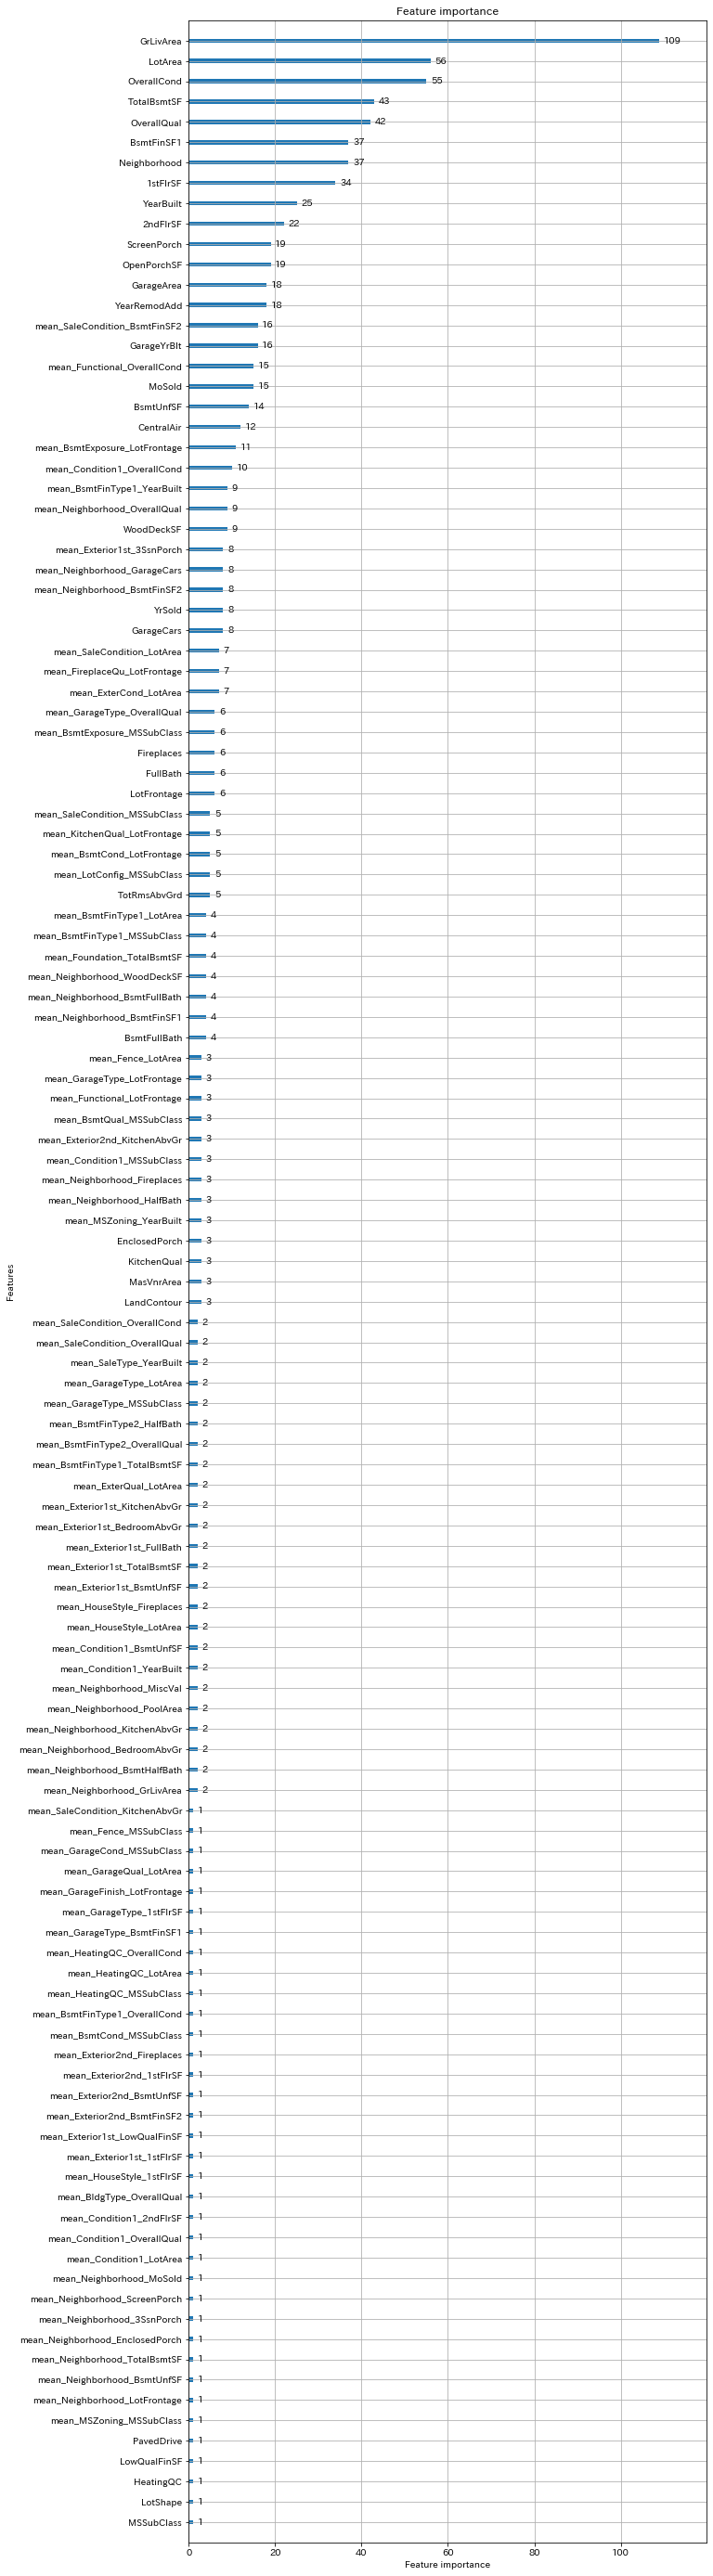

In [20]:
lgb.plot_importance(model, figsize=(10,50))

## 元の特徴量を抜く

In [14]:
data = pd.read_csv('../house price/alldata_many_cols.csv')
data = data.iloc[:,1:] 
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data.drop(cats, axis=1, inplace=True)
data.drop(nums, axis=1, inplace=True)
train = data[:len(train)]
test = data[len(train):]

C:\Users\user\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (72) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
data.to_csv('alldata_mean_cols.csv')

In [16]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [17]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 7,
    'max_depth': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            )

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           )

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281041	valid_1's rmse: 0.271583
[20]	training's rmse: 0.207551	valid_1's rmse: 0.205139
[30]	training's rmse: 0.162801	valid_1's rmse: 0.1698
[40]	training's rmse: 0.135723	valid_1's rmse: 0.153152
[50]	training's rmse: 0.11888	valid_1's rmse: 0.144612
[60]	training's rmse: 0.107879	valid_1's rmse: 0.141044
[70]	training's rmse: 0.100417	valid_1's rmse: 0.139603
[80]	training's rmse: 0.0950163	valid_1's rmse: 0.139493
[90]	training's rmse: 0.0909578	valid_1's rmse: 0.139098
[100]	training's rmse: 0.0877353	valid_1's rmse: 0.139262
Early stopping, best iteration is:
[90]	training's rmse: 0.0909578	valid_1's rmse: 0.139098
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282168	valid_1's rmse: 0.273739
[20]	training's rmse: 0.210301	valid_1's rmse: 0.20616
[30]	training's rmse: 0.167159	valid_1's rmse: 0.165996
[40]	training's rmse: 0.141713	valid_1's rmse: 0.142193
[5

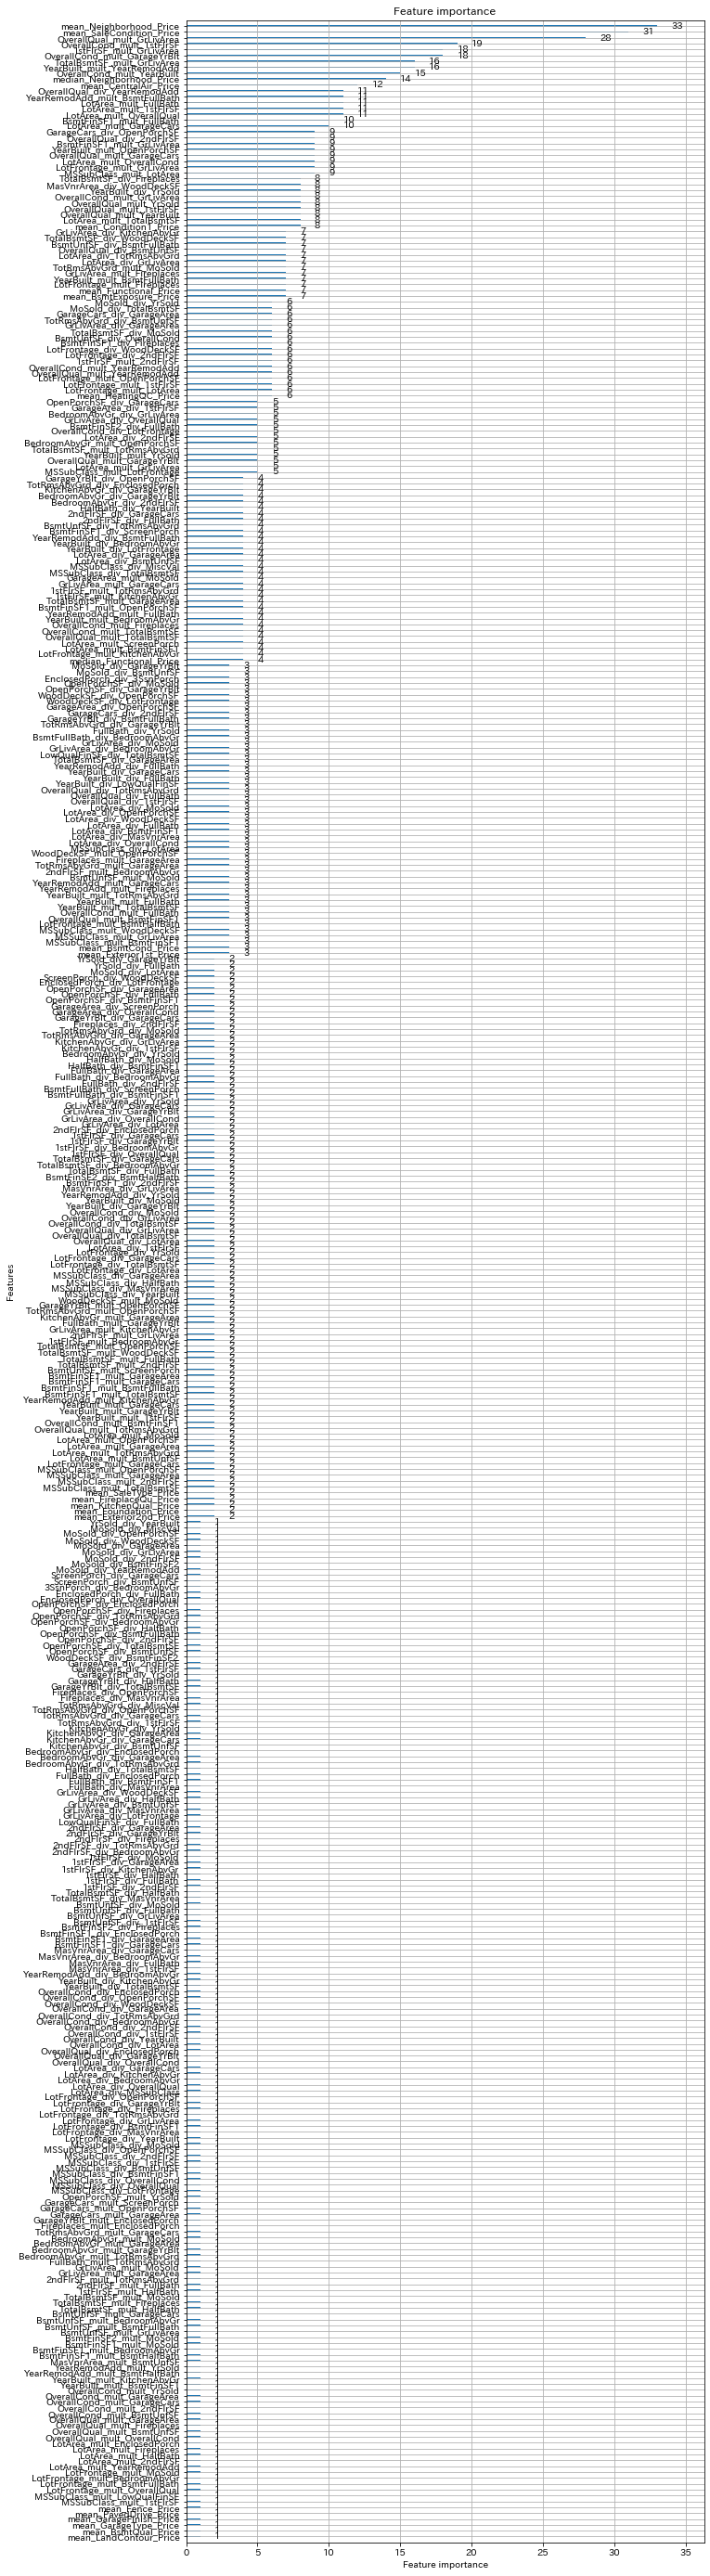

In [18]:
lgb.plot_importance(model, figsize=(10,50))

# カテゴリ変数でグループ化された数値変数の平均値からの差

In [20]:
train = pd.read_csv('../house price/train.csv')
test = pd.read_csv('../house price/test.csv')
Id = test.Id
target = train.SalePrice
data = pd.read_csv('../house price/004_data.csv')
nums = [f for f in train.columns if train.dtypes[f] != 'object']
nums.remove('SalePrice')
nums.remove('Id')
cats = [f for f in train.columns if train.dtypes[f] == 'object']
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
train['SalePrice'] = np.log(train['SalePrice'])
alldata = pd.concat([train, test], sort=False)
alldata['LotFrontage'] = alldata.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
mode_fill_li = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual'
                 , 'Functional', 'SaleType']
None_fill_li = [ 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType'
                , 'GarageFinish','GarageQual', 'GarageCond']
fill_0_li = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']
for i in mode_fill_li:
    alldata[i].fillna(alldata[i].mode()[0], inplace=True)

for j in None_fill_li:
    alldata[j].fillna('None',inplace=True)

for k in fill_0_li:
    alldata[k].fillna(0, inplace=True)

In [21]:
def delta_cat_group_feature(df, train_df, cat_f, target, agg):
    for c in cat_f:
        for t in target:
            group = train_df.groupby(c).agg({t: [agg]})
            group.columns = [agg + '_' + c + '_'+ t]
            group.reset_index(inplace=True)
            df = df.merge(group, on=[c], how='left')
            df['delta_'+ agg + '_' + c + '_'+ t] = df[t] - df[agg + '_' + c + '_'+ t]
            
    return df

In [22]:
alldata = delta_cat_group_feature(alldata, train, cats, nums, 'mean')
alldata

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,mean_SaleCondition_ScreenPorch,delta_mean_SaleCondition_ScreenPorch,mean_SaleCondition_PoolArea,delta_mean_SaleCondition_PoolArea,mean_SaleCondition_MiscVal,delta_mean_SaleCondition_MiscVal,mean_SaleCondition_MoSold,delta_mean_SaleCondition_MoSold,mean_SaleCondition_YrSold,delta_mean_SaleCondition_YrSold
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,15.336394,-15.336394,1.454925,-1.454925,52.103506,-52.103506,6.231219,-4.231219,2007.897329,0.102671
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,15.336394,-15.336394,1.454925,-1.454925,52.103506,-52.103506,6.231219,-1.231219,2007.897329,-0.897329
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,15.336394,-15.336394,1.454925,-1.454925,52.103506,-52.103506,6.231219,2.768781,2007.897329,0.102671
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,20.108911,-20.108911,10.564356,-10.564356,10.099010,-10.099010,6.465347,-4.465347,2007.663366,-1.663366
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,15.336394,-15.336394,1.454925,-1.454925,52.103506,-52.103506,6.231219,5.768781,2007.897329,0.102671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,15.336394,-15.336394,1.454925,-1.454925,52.103506,-52.103506,6.231219,-0.231219,2007.897329,-1.897329
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,20.108911,-20.108911,10.564356,-10.564356,10.099010,-10.099010,6.465347,-2.465347,2007.663366,-1.663366
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,20.108911,-20.108911,10.564356,-10.564356,10.099010,-10.099010,6.465347,2.534653,2007.663366,-1.663366
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,15.336394,-15.336394,1.454925,-1.454925,52.103506,647.896494,6.231219,0.768781,2007.897329,-1.897329


In [23]:
for c in cats:
    for t in nums:
        alldata.drop('mean' + '_' + c + '_'+ t, axis=1, inplace=True)

In [24]:
alldata.shape

(2919, 1628)

In [25]:
alldata.to_csv('alldata_delta_cols.csv')

In [26]:
data = pd.read_csv('../house price/alldata_delta_cols.csv')
data = data.iloc[:,1:] 
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = data[:len(train)]
test = data[len(train):]
categorical_cols = cats

C:\Users\user\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (72) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})
print(train.shape, test.shape)

(1460, 1628) (1459, 1628)


In [28]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [29]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 7,
    'max_depth': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            )

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           )

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287699	valid_1's rmse: 0.276594
[20]	training's rmse: 0.217528	valid_1's rmse: 0.214065
[30]	training's rmse: 0.172803	valid_1's rmse: 0.177838
[40]	training's rmse: 0.14499	valid_1's rmse: 0.159292
[50]	training's rmse: 0.126647	valid_1's rmse: 0.149105
[60]	training's rmse: 0.114096	valid_1's rmse: 0.143953
[70]	training's rmse: 0.105248	valid_1's rmse: 0.141748
[80]	training's rmse: 0.0987631	valid_1's rmse: 0.140478
[90]	training's rmse: 0.0940404	valid_1's rmse: 0.139591
[100]	training's rmse: 0.0902769	valid_1's rmse: 0.139368
[110]	training's rmse: 0.0869855	valid_1's rmse: 0.139537
[120]	training's rmse: 0.0841457	valid_1's rmse: 0.139113
Early stopping, best iteration is:
[117]	training's rmse: 0.0848579	valid_1's rmse: 0.139031
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287774	valid_1's rmse: 0.284265
[20]	training's rmse: 0.218518	valid_1's rmse: 0.2

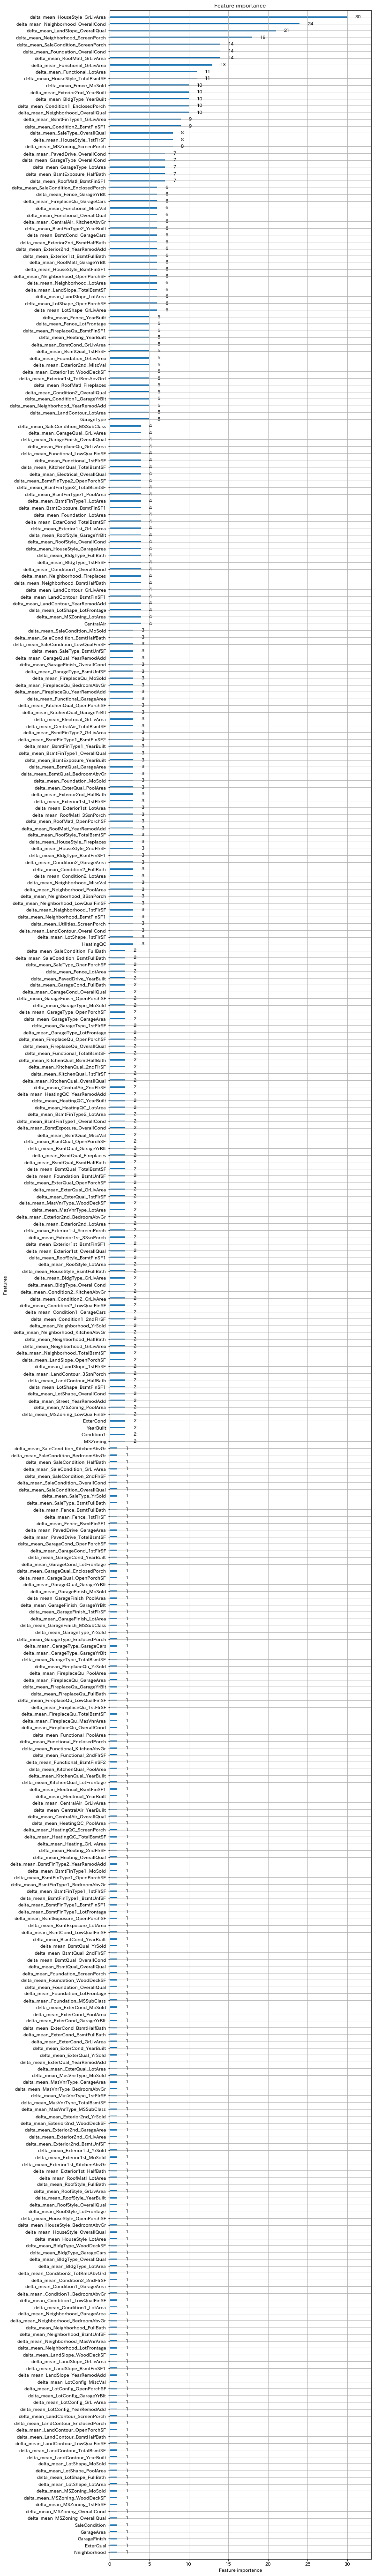

In [30]:
lgb.plot_importance(model, figsize=(10,100))

In [31]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)

In [32]:
data.drop(cats, axis=1, inplace=True)
data.drop(nums, axis=1, inplace=True)

In [33]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance

,importance
delta_mean_HouseStyle_GrLivArea,30
delta_mean_Neighborhood_OverallCond,24
delta_mean_LandSlope_OverallQual,21
delta_mean_Neighborhood_ScreenPorch,18
delta_mean_Foundation_OverallCond,14
...,...
delta_mean_RoofMatl_GarageCars,0
delta_mean_RoofMatl_TotRmsAbvGrd,0
delta_mean_RoofMatl_KitchenAbvGr,0
delta_mean_RoofMatl_BedroomAbvGr,0


In [ ]:
data[importance.index[:300]].to_csv('delta_f_top100.csv')

## 元の特徴量を抜く

In [39]:
data = pd.read_csv('../house price/alldata_delta_cols.csv')
data = data.iloc[:,1:] 
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data.drop(cats, axis=1, inplace=True)
data.drop(nums, axis=1, inplace=True)
train = data[:len(train)]
test = data[len(train):]
categorical_cols = cats

C:\Users\user\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (72) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [41]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 7,
    'max_depth': 4,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            )

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           )

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)


    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287704	valid_1's rmse: 0.276581
[20]	training's rmse: 0.217487	valid_1's rmse: 0.214006
[30]	training's rmse: 0.172912	valid_1's rmse: 0.176539
[40]	training's rmse: 0.144939	valid_1's rmse: 0.157955
[50]	training's rmse: 0.126744	valid_1's rmse: 0.14837
[60]	training's rmse: 0.114321	valid_1's rmse: 0.143642
[70]	training's rmse: 0.105768	valid_1's rmse: 0.141498
[80]	training's rmse: 0.0989651	valid_1's rmse: 0.140683
[90]	training's rmse: 0.094022	valid_1's rmse: 0.139989
[100]	training's rmse: 0.090221	valid_1's rmse: 0.139516
[110]	training's rmse: 0.0869534	valid_1's rmse: 0.139698
Early stopping, best iteration is:
[103]	training's rmse: 0.089277	valid_1's rmse: 0.139314
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287774	valid_1's rmse: 0.284265
[20]	training's rmse: 0.218518	valid_1's rmse: 0.219232
[30]	training's rmse: 0.176639	valid_1's rmse: 0.178545

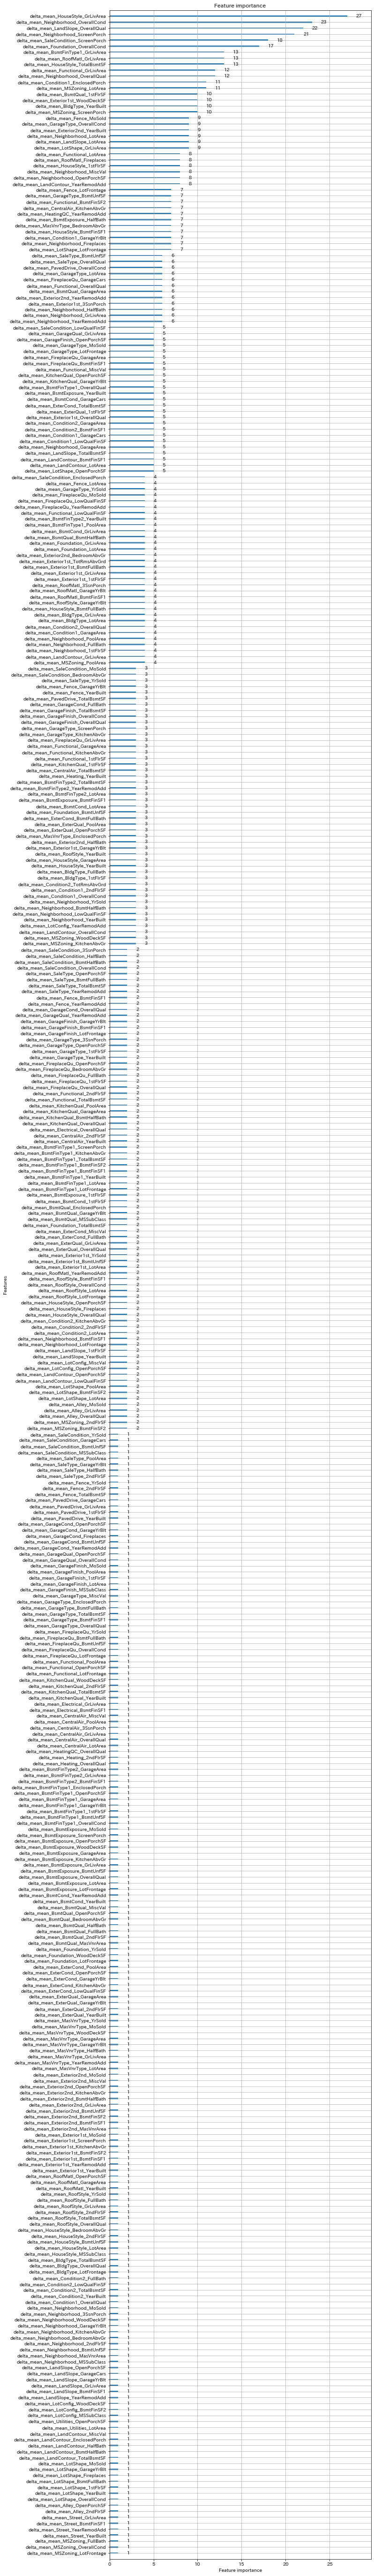

In [42]:
lgb.plot_importance(model, figsize=(10,100))

In [43]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance

,importance
delta_mean_HouseStyle_GrLivArea,27
delta_mean_Neighborhood_OverallCond,23
delta_mean_LandSlope_OverallQual,22
delta_mean_Neighborhood_ScreenPorch,21
delta_mean_SaleCondition_ScreenPorch,18
...,...
delta_mean_BsmtQual_PoolArea,0
delta_mean_Utilities_ScreenPorch,0
delta_mean_BsmtQual_MoSold,0
delta_mean_BsmtQual_YrSold,0


In [44]:
data[importance.index[:300]]

,delta_mean_HouseStyle_GrLivArea,delta_mean_Neighborhood_OverallCond,delta_mean_LandSlope_OverallQual,delta_mean_Neighborhood_ScreenPorch,delta_mean_SaleCondition_ScreenPorch,delta_mean_Foundation_OverallCond,delta_mean_RoofMatl_GrLivArea,delta_mean_HouseStyle_TotalBsmtSF,delta_mean_BsmtFinType1_GrLivArea,delta_mean_Functional_GrLivArea,...,delta_mean_PavedDrive_YearBuilt,delta_mean_PavedDrive_1stFlrSF,delta_mean_FireplaceQu_BsmtFullBath,delta_mean_BsmtFinType1_OverallCond,delta_mean_FireplaceQu_BsmtUnfSF,delta_mean_Foundation_YrSold,delta_mean_BsmtQual_BedroomAbvGr,delta_mean_BsmtQual_HalfBath,delta_mean_MSZoning_LotFrontage,delta_mean_BsmtQual_2ndFlrSF
0,-177.411236,-0.240000,0.879884,-4.300000,-15.336394,-0.202473,205.359833,-82.997753,34.033493,203.477206,...,27.819403,-325.575373,NaN,-0.299043,NaN,0.233385,0.173139,0.503236,-9.680043,432.097087
1,-46.599174,1.727273,-0.120116,-56.363636,-15.336394,2.170347,-242.640167,55.015152,-86.763636,-244.522794,...,0.819403,80.424627,-0.501597,1.986364,-233.338658,-0.865931,0.173139,-0.496764,5.319957,-421.902913
2,-101.411236,-0.240000,0.879884,-4.300000,-15.336394,-0.202473,281.359833,-18.997753,110.033493,279.477206,...,25.819403,-261.575373,0.498403,-0.299043,-83.338658,0.233385,0.173139,0.503236,-6.680043,444.097087
3,-170.411236,-1.588235,0.879884,-30.176471,-20.108911,-1.198630,212.359833,-182.997753,368.236364,210.477206,...,-60.180597,-220.575373,0.573684,-1.013636,-183.850000,-1.732877,0.052388,-0.286595,-14.680043,482.249615
4,310.588764,-0.219512,1.879884,-13.512195,-15.336394,-0.202473,693.359833,206.002247,522.033493,691.477206,...,24.819403,-36.575373,0.498403,-0.299043,-27.338658,0.233385,1.173139,0.503236,9.319957,631.097087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-795.411236,1.470588,-2.120116,0.000000,-15.336394,1.170347,-412.640167,-392.997753,-466.267442,-414.522794,...,-5.180597,-635.575373,NaN,1.462791,NaN,-1.865931,0.052388,0.713405,-31.366834,272.249615
2915,-795.411236,-0.529412,-2.120116,0.000000,-20.108911,-0.829653,-412.640167,-392.997753,-320.909774,-414.522794,...,-5.180597,-635.575373,NaN,-0.774436,NaN,-1.865931,0.052388,0.713405,-31.366834,272.249615
2916,-84.599174,1.632653,-1.120116,-11.632653,-20.108911,1.170347,-280.640167,17.015152,-124.763636,-282.522794,...,-15.180597,42.424627,0.498403,0.986364,-517.338658,-1.865931,1.052388,-0.286595,85.319957,-273.750385
2917,-3.378378,-0.367347,-1.120116,-11.632653,-15.336394,-0.202473,-534.640167,42.945946,-705.966507,-536.522794,...,16.819403,-211.575373,NaN,-0.299043,NaN,-1.766615,0.173139,-0.496764,-12.680043,-421.902913


In [45]:
data[importance.index[:300]].to_csv('delta_f_top200.csv')